# Import Data

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from model.prediction_engine import get_final_data
# final_data = get_final_data(save_to_csv=False)
final_data = pd.read_csv('data/final_data.csv')

## Process Data

In [3]:
import torch
import tensorly as tl
%load_ext autoreload
%autoreload 2

from model.prediction_engine import PredictionTestEngine

final_data = final_data.sort_values(['year_month', 'GVKEY'])
final_data['trt1m'] = pd.to_numeric(final_data['trt1m'], errors='coerce')

# feature columns
feature_cols = [c for c in final_data.columns 
                if c not in ['GVKEY','year_month','trt1m']]
for col in feature_cols:
    final_data[col] = pd.to_numeric(final_data[col], errors='coerce')

# Build Y (T × n_series)
Y_df = (final_data
    .pivot_table(index='year_month', columns='GVKEY', 
                 values='trt1m', aggfunc='mean')
    .sort_index().sort_index(axis=1)
)
Y_df = Y_df.apply(lambda x: (x - x.mean())/x.std(), axis=0)
Y = Y_df.to_numpy()

# Build X tensor (T × n_series × n_features)
X_list = []
for col in feature_cols:
    pivot = (final_data
        .pivot_table(index='year_month', columns='GVKEY', 
                     values=col, aggfunc='mean')
        .reindex(index=Y_df.index, columns=Y_df.columns)
    )
    pivot = pivot.apply(lambda x: (x - x.mean())/x.std(), axis=0)
    X_list.append(pivot.to_numpy())
X = np.stack(X_list, axis=2)

# Shift so that X[t] predicts Y[t+1]
# Ensure data is float32
X_all = np.nan_to_num(X[:-1, :, :]).astype(np.float32)
Y_all = np.nan_to_num(Y[1:, :]).astype(np.float32)

# Time index for the test (use first day of month)
time_index_all = pd.to_datetime(Y_df.index[1:], format='%Y-%m')

# Ensure tensorly backend
tl.set_backend("pytorch")
torch.set_default_tensor_type(torch.FloatTensor)
torch.set_default_dtype(torch.float32)



/usr/local/lib/python3.10/dist-packages/torch/__init__.py:1240: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


run_window: X_all shape (275, 127, 38), y_all shape (275, 127)
run_window: window_size=70, n_series=127, n_features=38
run_window: number of test windows=55


Rolling prediction:   0%|          | 0/55 [00:00<?, ?it/s]

Rolling prediction: 100%|██████████| 55/55 [06:10<00:00,  6.73s/it]


MILR components: 15
  P comp 0: [(127, 20), (38, 20)]
  P comp 1: [(127, 20), (38, 20)]
  P comp 2: [(127, 20), (38, 20)]
  P comp 3: [(127, 20), (38, 20)]
  P comp 4: [(127, 20), (38, 20)]
  P comp 5: [(127, 20), (38, 20)]
  P comp 6: [(127, 20), (38, 20)]
  P comp 7: [(127, 20), (38, 20)]
  P comp 8: [(127, 20), (38, 20)]
  P comp 9: [(127, 20), (38, 20)]
  P comp 10: [(127, 20), (38, 20)]
  P comp 11: [(127, 20), (38, 20)]
  P comp 12: [(127, 20), (38, 20)]
  P comp 13: [(127, 20), (38, 20)]
  P comp 14: [(127, 20), (38, 20)]
G shapes: [(1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20)]
Q shape: (127, 15)
D shape: (15,)
T_mat shape: (70, 15), W_mat shape: (4826, 15)
Overall metrics:
mse: 1.2422
r2: -0.0005
directional_accuracy: 0.5465


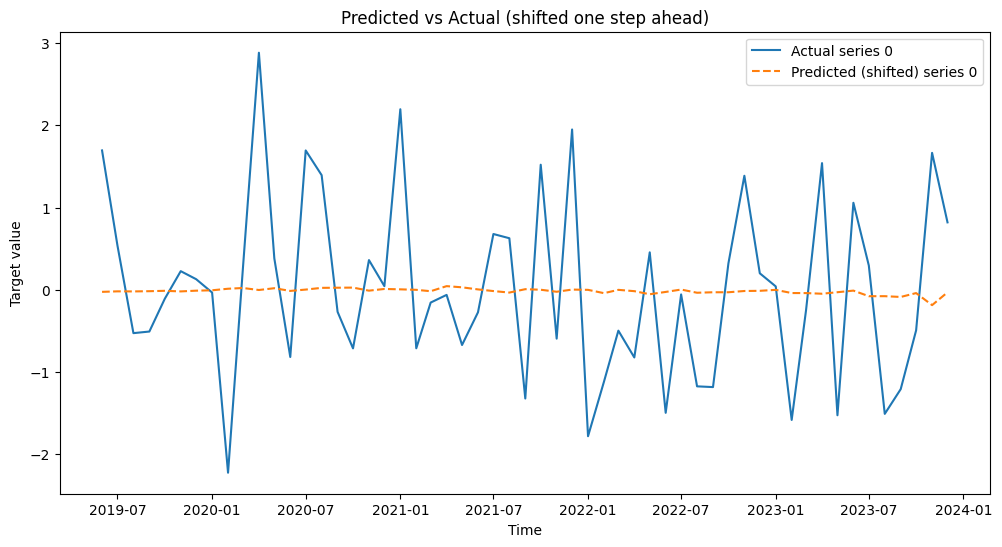

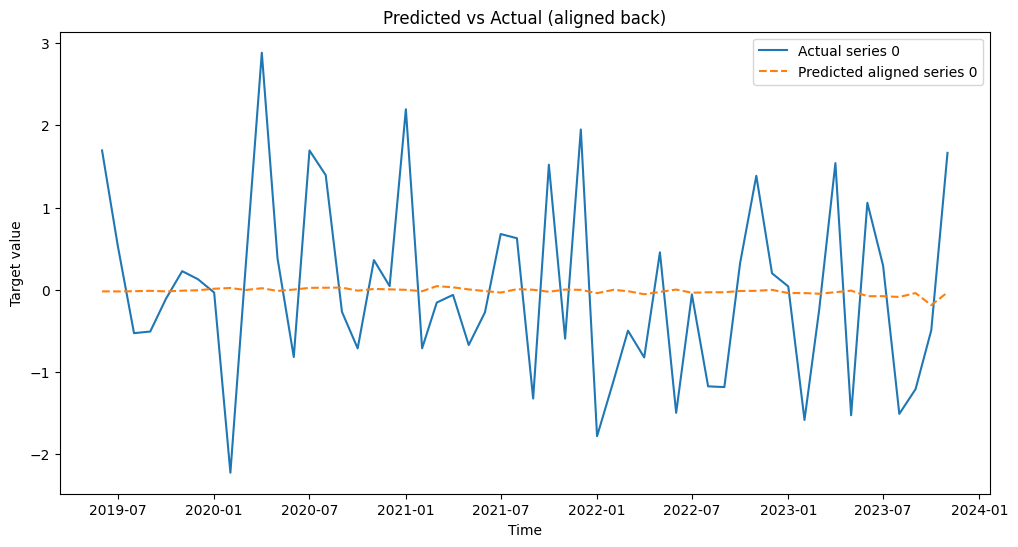

In [4]:
from model.prediction_engine import PredictionTestEngine

# Instantiate engine
window_size = 70
train_start = int(0.80 * X_all.shape[0])
engine = PredictionTestEngine(
    X_all,
    Y_all,
    window_size=window_size,
    time_index=time_index_all,
    train_start=train_start,
)

y_pred, y_true, times, metrics = engine.run_window(
    method="hopls_milr"
    , R=15, Ln=(20, 20), epsilon=1e-8, verbose=True, n_jobs=1, lambda_X = 1, lambda_Y = 1, alpha=0.03
)

print("Overall metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# Plot results for series 0
engine.plot_results(series_indices=[0])

Overall metrics:
mse: 1.2383
r2: 0.0027
directional_accuracy: 0.5280


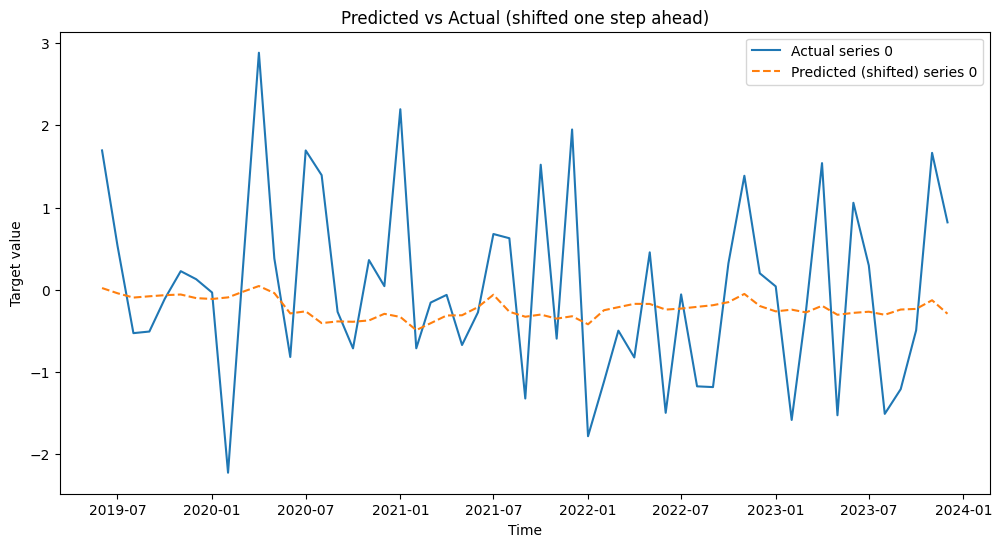

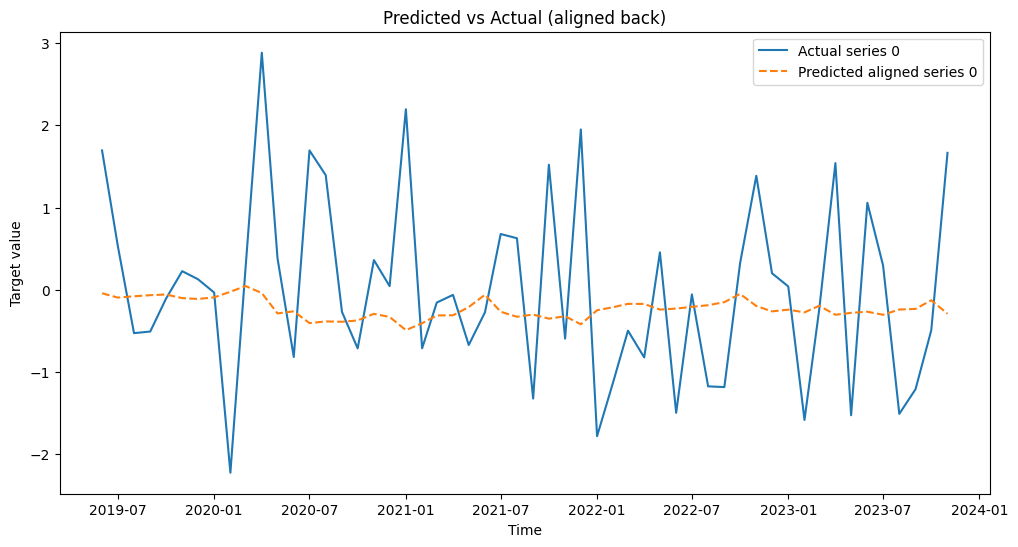

In [29]:
from model.prediction_engine import PredictionTestEngine

# Instantiate engine
window_size = 70
train_start = int(0.80 * X_all.shape[0])
engine = PredictionTestEngine(
    X_all,
    Y_all,
    window_size=window_size,
    time_index=time_index_all,
    train_start=train_start,
)

y_pred, y_true, times, metrics = engine.run_window(
    method="linear_regression"
)

print("Overall metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# Plot results for series 0
engine.plot_results(series_indices=[0])

run_window: X_all shape (275, 127, 38), y_all shape (275, 127)
run_window: window_size=80, n_series=127, n_features=38
run_window: number of test windows=138


Rolling prediction: 100%|██████████| 138/138 [19:33<00:00,  8.50s/it]


MILR components: 20
  P comp 0: [(127, 20), (38, 20)]
  P comp 1: [(127, 20), (38, 20)]
  P comp 2: [(127, 20), (38, 20)]
  P comp 3: [(127, 20), (38, 20)]
  P comp 4: [(127, 20), (38, 20)]
  P comp 5: [(127, 20), (38, 20)]
  P comp 6: [(127, 20), (38, 20)]
  P comp 7: [(127, 20), (38, 20)]
  P comp 8: [(127, 20), (38, 20)]
  P comp 9: [(127, 20), (38, 20)]
  P comp 10: [(127, 20), (38, 20)]
  P comp 11: [(127, 20), (38, 20)]
  P comp 12: [(127, 20), (38, 20)]
  P comp 13: [(127, 20), (38, 20)]
  P comp 14: [(127, 20), (38, 20)]
  P comp 15: [(127, 20), (38, 20)]
  P comp 16: [(127, 20), (38, 20)]
  P comp 17: [(127, 20), (38, 20)]
  P comp 18: [(127, 20), (38, 20)]
  P comp 19: [(127, 20), (38, 20)]
G shapes: [(1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20)]
Q shape: (127, 20)


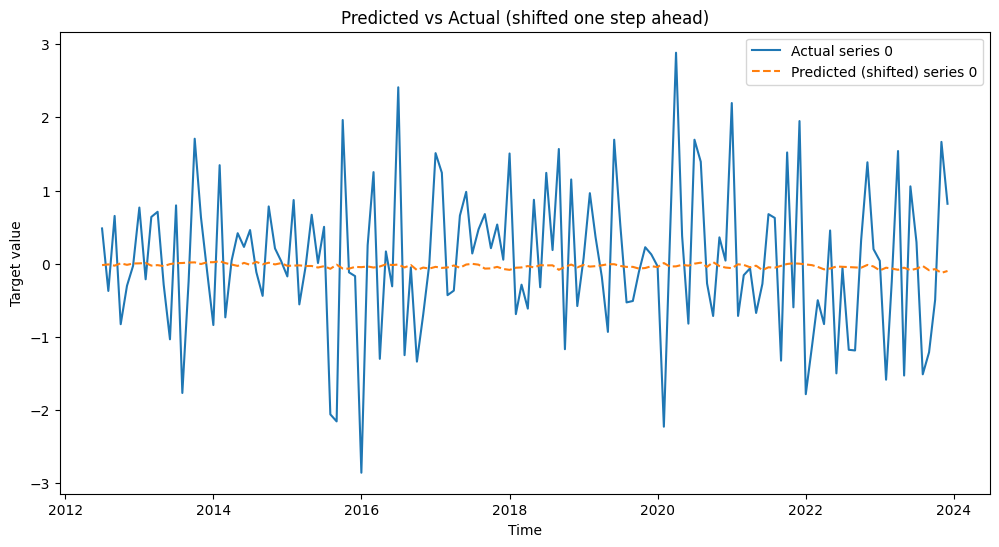

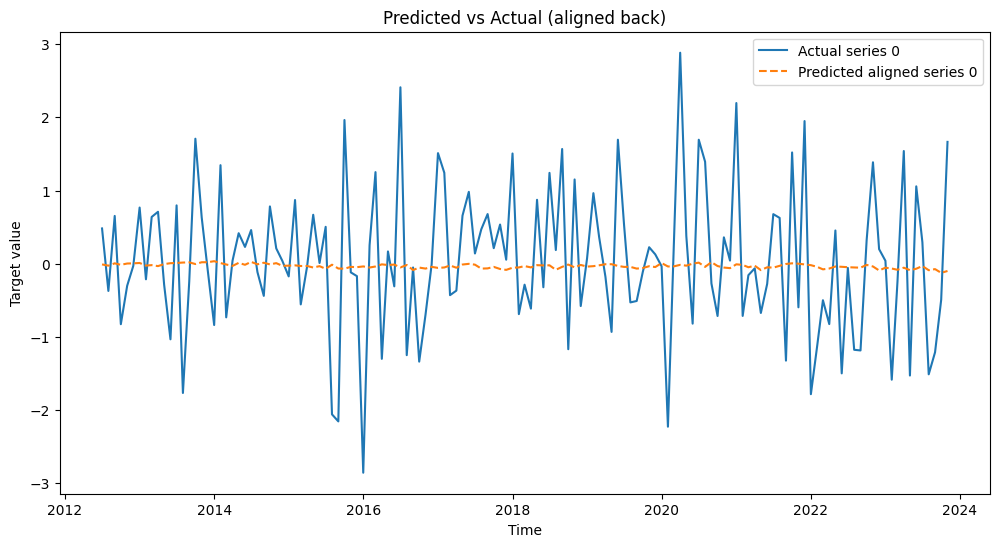

In [32]:
from model.prediction_engine import PredictionTestEngine

# Instantiate engine
window_size = 80
train_start = int(0.50 * X_all.shape[0])
engine = PredictionTestEngine(
    X_all,
    Y_all,
    window_size=window_size,
    time_index=time_index_all,
    train_start=train_start,
)

y_pred, y_true, times, metrics = engine.run_window(
    method="hopls_milr"
    , R=20, Ln=(20, 20), epsilon=1e-8, verbose=True, n_jobs=1, lambda_X = 1, lambda_Y = 1, alpha=1
)

print("Overall metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# Plot results for series 0
engine.plot_results(series_indices=[0])

run_window: X_all shape (275, 127, 38), y_all shape (275, 127)
run_window: window_size=80, n_series=127, n_features=38
run_window: number of test windows=138


Rolling prediction:   0%|          | 0/138 [00:00<?, ?it/s]

Rolling prediction: 100%|██████████| 138/138 [14:18<00:00,  6.22s/it]


MILR components: 15
  P comp 0: [(127, 20), (38, 20)]
  P comp 1: [(127, 20), (38, 20)]
  P comp 2: [(127, 20), (38, 20)]
  P comp 3: [(127, 20), (38, 20)]
  P comp 4: [(127, 20), (38, 20)]
  P comp 5: [(127, 20), (38, 20)]
  P comp 6: [(127, 20), (38, 20)]
  P comp 7: [(127, 20), (38, 20)]
  P comp 8: [(127, 20), (38, 20)]
  P comp 9: [(127, 20), (38, 20)]
  P comp 10: [(127, 20), (38, 20)]
  P comp 11: [(127, 20), (38, 20)]
  P comp 12: [(127, 20), (38, 20)]
  P comp 13: [(127, 20), (38, 20)]
  P comp 14: [(127, 20), (38, 20)]
G shapes: [(1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20)]
Q shape: (127, 15)
D shape: (15,)
T_mat shape: (80, 15), W_mat shape: (4826, 15)
Overall metrics:
mse: 0.8886
r2: 0.0009
directional_accuracy: 0.5321


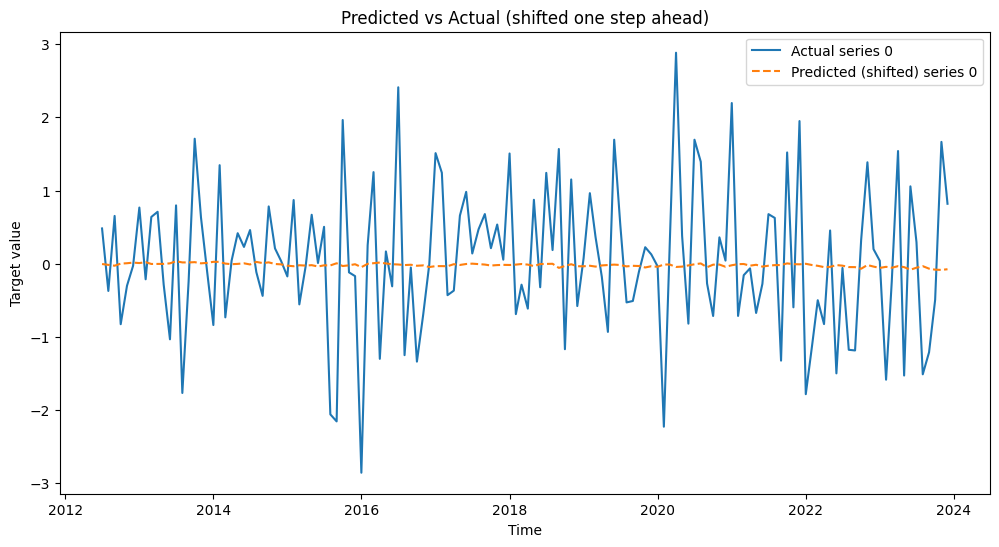

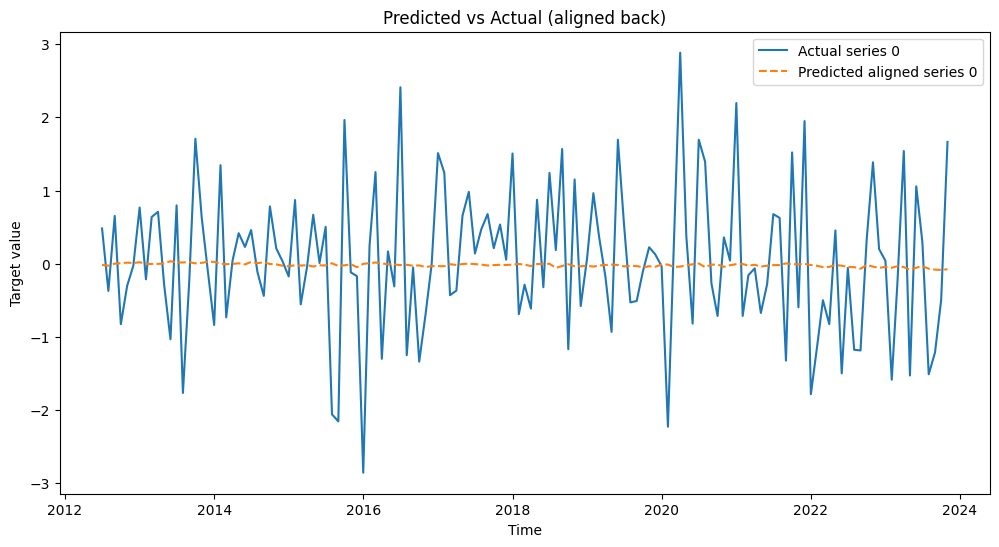

In [18]:
from model.prediction_engine import PredictionTestEngine

# Instantiate engine
window_size = 80
train_start = int(0.50 * X_all.shape[0])
engine = PredictionTestEngine(
    X_all,
    Y_all,
    window_size=window_size,
    time_index=time_index_all,
    train_start=train_start,
)

y_pred, y_true, times, metrics = engine.run_window(
    method="hopls_milr"
    , R=15, Ln=(20, 20), epsilon=1e-8, verbose=True, n_jobs=1, lambda_X = 1, lambda_Y = 1, alpha=1
)

print("Overall metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# Plot results for series 0
engine.plot_results(series_indices=[0])

In [ ]:
from model.prediction_engine import PredictionTestEngine

# Instantiate engine
window_size = 80
train_start = int(0.50 * X_all.shape[0])
engine = PredictionTestEngine(
    X_all,
    Y_all,
    window_size=window_size,
    time_index=time_index_all,
    train_start=train_start,
)

y_pred, y_true, times, metrics = engine.run_window(
    method="hopls_milr"
    , R=15, Ln=(20, 20), epsilon=1e-8, verbose=True, n_jobs=1, lambda_X = 1, lambda_Y = 1, alpha=1.2
)

print("Overall metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# Plot results for series 0
engine.plot_results(series_indices=[0])

run_window: X_all shape (275, 127, 38), y_all shape (275, 127)
run_window: window_size=80, n_series=127, n_features=38
run_window: number of test windows=138


Rolling prediction:   0%|          | 0/138 [00:00<?, ?it/s]

Rolling prediction: 100%|██████████| 138/138 [13:34<00:00,  5.90s/it]


MILR components: 15
  P comp 0: [(127, 15), (38, 15)]
  P comp 1: [(127, 15), (38, 15)]
  P comp 2: [(127, 15), (38, 15)]
  P comp 3: [(127, 15), (38, 15)]
  P comp 4: [(127, 15), (38, 15)]
  P comp 5: [(127, 15), (38, 15)]
  P comp 6: [(127, 15), (38, 15)]
  P comp 7: [(127, 15), (38, 15)]
  P comp 8: [(127, 15), (38, 15)]
  P comp 9: [(127, 15), (38, 15)]
  P comp 10: [(127, 15), (38, 15)]
  P comp 11: [(127, 15), (38, 15)]
  P comp 12: [(127, 15), (38, 15)]
  P comp 13: [(127, 15), (38, 15)]
  P comp 14: [(127, 15), (38, 15)]
G shapes: [(1, 15, 15), (1, 15, 15), (1, 15, 15), (1, 15, 15), (1, 15, 15), (1, 15, 15), (1, 15, 15), (1, 15, 15), (1, 15, 15), (1, 15, 15), (1, 15, 15), (1, 15, 15), (1, 15, 15), (1, 15, 15), (1, 15, 15)]
Q shape: (127, 15)
D shape: (15,)
T_mat shape: (80, 15), W_mat shape: (4826, 15)
Overall metrics:
mse: 0.8899
r2: -0.0007
directional_accuracy: 0.5078


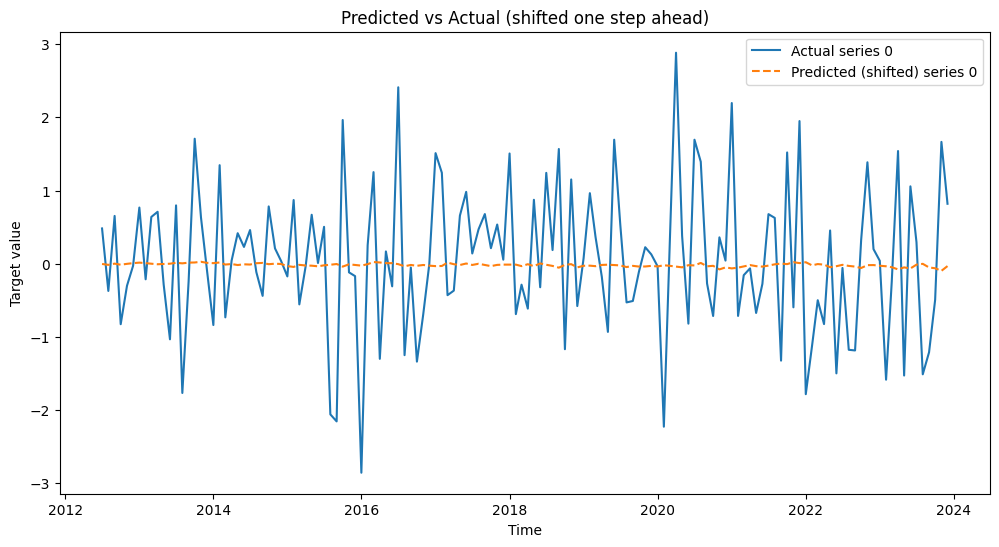

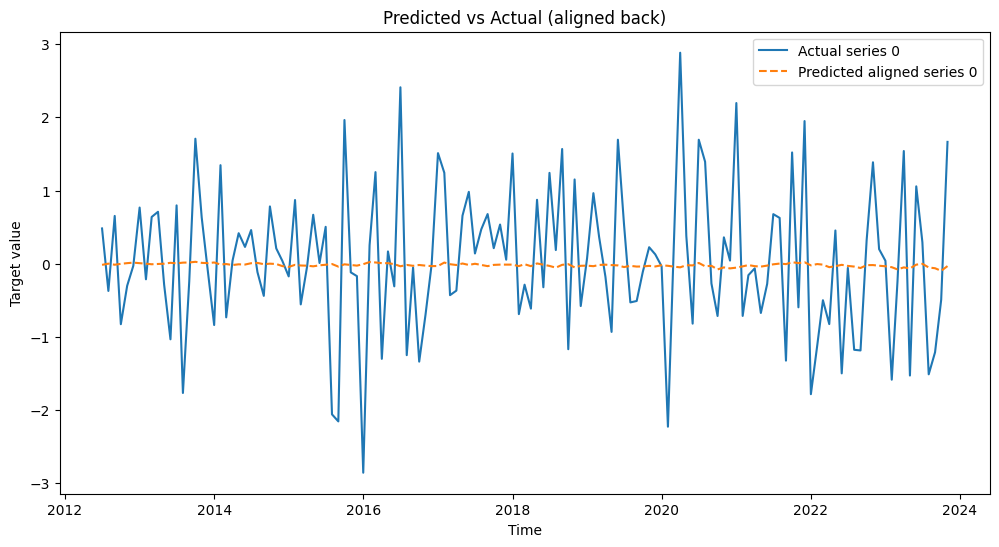

In [33]:
from model.prediction_engine import PredictionTestEngine

# Instantiate engine
window_size = 80
train_start = int(0.50 * X_all.shape[0])
engine = PredictionTestEngine(
    X_all,
    Y_all,
    window_size=window_size,
    time_index=time_index_all,
    train_start=train_start,
)

y_pred, y_true, times, metrics = engine.run_window(
    method="hopls_milr"
    , R=15, Ln=(15, 15), epsilon=1e-8, verbose=True, n_jobs=1, lambda_X = 1, lambda_Y = 1, alpha=1
)

print("Overall metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# Plot results for series 0
engine.plot_results(series_indices=[0])

run_window: X_all shape (275, 127, 38), y_all shape (275, 127)
run_window: window_size=70, n_series=127, n_features=38
run_window: number of test windows=55


Rolling prediction:   0%|          | 0/55 [00:00<?, ?it/s]

Rolling prediction: 100%|██████████| 55/55 [07:57<00:00,  8.67s/it]


MILR components: 20
  P comp 0: [(127, 20), (38, 20)]
  P comp 1: [(127, 20), (38, 20)]
  P comp 2: [(127, 20), (38, 20)]
  P comp 3: [(127, 20), (38, 20)]
  P comp 4: [(127, 20), (38, 20)]
  P comp 5: [(127, 20), (38, 20)]
  P comp 6: [(127, 20), (38, 20)]
  P comp 7: [(127, 20), (38, 20)]
  P comp 8: [(127, 20), (38, 20)]
  P comp 9: [(127, 20), (38, 20)]
  P comp 10: [(127, 20), (38, 20)]
  P comp 11: [(127, 20), (38, 20)]
  P comp 12: [(127, 20), (38, 20)]
  P comp 13: [(127, 20), (38, 20)]
  P comp 14: [(127, 20), (38, 20)]
  P comp 15: [(127, 20), (38, 20)]
  P comp 16: [(127, 20), (38, 20)]
  P comp 17: [(127, 20), (38, 20)]
  P comp 18: [(127, 20), (38, 20)]
  P comp 19: [(127, 20), (38, 20)]
G shapes: [(1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20)]
Q shape: (127, 20)


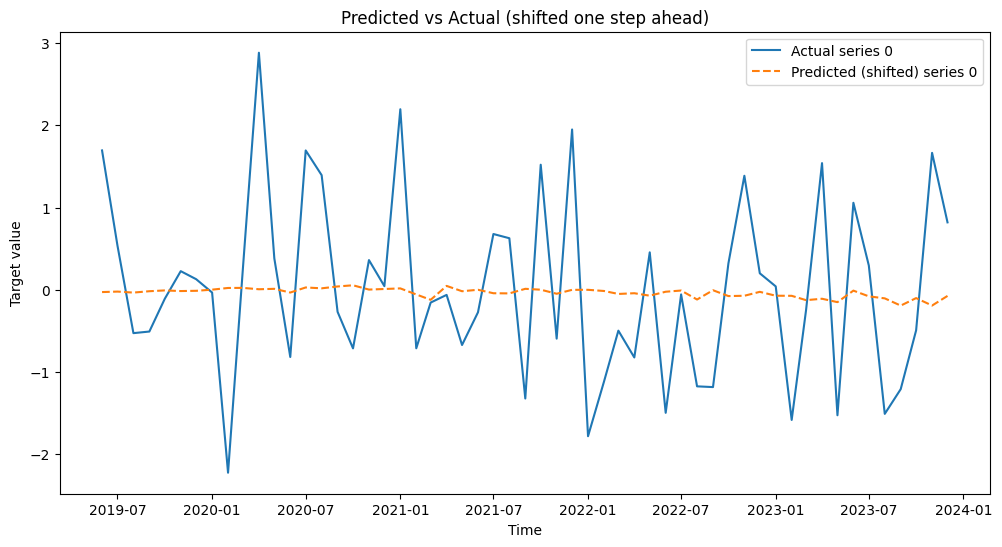

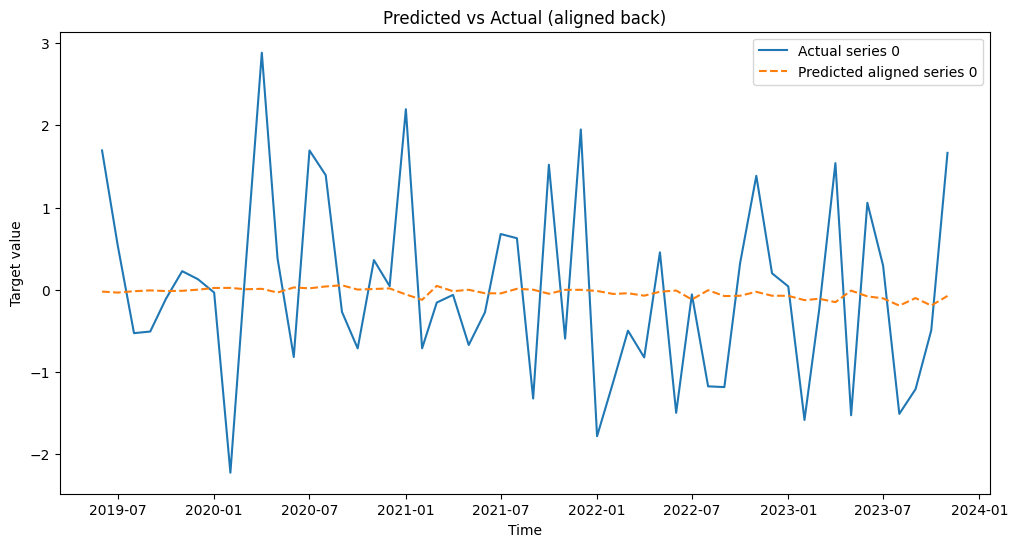

In [7]:
from model.prediction_engine import PredictionTestEngine

# Instantiate engine
window_size = 70
train_start = int(0.80 * X_all.shape[0])
engine = PredictionTestEngine(
    X_all,
    Y_all,
    window_size=window_size,
    time_index=time_index_all,
    train_start=train_start,
)

y_pred, y_true, times, metrics = engine.run_window(
    method="hopls_milr"
    , R=20, Ln=(20, 20), epsilon=1e-8, verbose=True, n_jobs=1, lambda_X = 1, lambda_Y = 1, alpha=0.03
)

print("Overall metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# Plot results for series 0
engine.plot_results(series_indices=[0])

run_window: X_all shape (275, 127, 38), y_all shape (275, 127)
run_window: window_size=70, n_series=127, n_features=38
run_window: number of test windows=55


Rolling prediction: 100%|██████████| 55/55 [06:38<00:00,  7.25s/it]


MILR components: 15
  P comp 0: [(127, 20), (38, 20)]
  P comp 1: [(127, 20), (38, 20)]
  P comp 2: [(127, 20), (38, 20)]
  P comp 3: [(127, 20), (38, 20)]
  P comp 4: [(127, 20), (38, 20)]
  P comp 5: [(127, 20), (38, 20)]
  P comp 6: [(127, 20), (38, 20)]
  P comp 7: [(127, 20), (38, 20)]
  P comp 8: [(127, 20), (38, 20)]
  P comp 9: [(127, 20), (38, 20)]
  P comp 10: [(127, 20), (38, 20)]
  P comp 11: [(127, 20), (38, 20)]
  P comp 12: [(127, 20), (38, 20)]
  P comp 13: [(127, 20), (38, 20)]
  P comp 14: [(127, 20), (38, 20)]
G shapes: [(1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20)]
Q shape: (127, 15)
D shape: (15,)
T_mat shape: (70, 15), W_mat shape: (4826, 15)
Overall metrics:
mse: 1.2443
r2: -0.0022
directional_accuracy: 0.4975


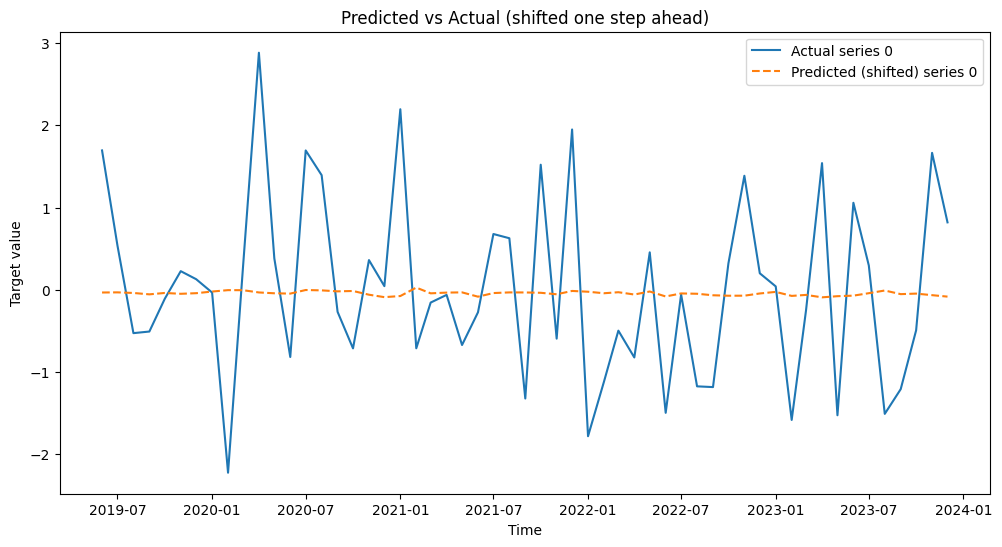

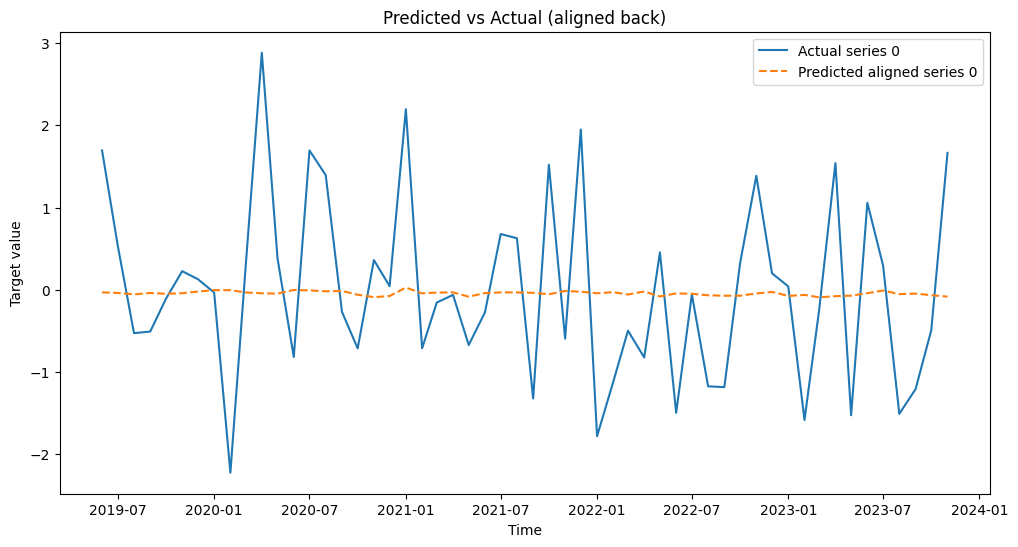

In [6]:
from model.prediction_engine import PredictionTestEngine

# Instantiate engine
window_size = 70
train_start = int(0.80 * X_all.shape[0])
engine = PredictionTestEngine(
    X_all,
    Y_all,
    window_size=window_size,
    time_index=time_index_all,
    train_start=train_start,
)

y_pred, y_true, times, metrics = engine.run_window(
    method="hopls_milr"
    , R=15, Ln=(20, 20), epsilon=1e-8, verbose=True, n_jobs=1, lambda_X = 1, lambda_Y = 1, alpha=1.3
)

print("Overall metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# Plot results for series 0
engine.plot_results(series_indices=[0])

run_window: X_all shape (275, 127, 38), y_all shape (275, 127)
run_window: window_size=70, n_series=127, n_features=38
run_window: number of test windows=83


Rolling prediction: 100%|██████████| 83/83 [05:55<00:00,  4.28s/it]


MILR components: 40
  P comp 0: [(127, 6), (38, 6)]
  P comp 1: [(127, 6), (38, 6)]
  P comp 2: [(127, 6), (38, 6)]
  P comp 3: [(127, 6), (38, 6)]
  P comp 4: [(127, 6), (38, 6)]
  P comp 5: [(127, 6), (38, 6)]
  P comp 6: [(127, 6), (38, 6)]
  P comp 7: [(127, 6), (38, 6)]
  P comp 8: [(127, 6), (38, 6)]
  P comp 9: [(127, 6), (38, 6)]
  P comp 10: [(127, 6), (38, 6)]
  P comp 11: [(127, 6), (38, 6)]
  P comp 12: [(127, 6), (38, 6)]
  P comp 13: [(127, 6), (38, 6)]
  P comp 14: [(127, 6), (38, 6)]
  P comp 15: [(127, 6), (38, 6)]
  P comp 16: [(127, 6), (38, 6)]
  P comp 17: [(127, 6), (38, 6)]
  P comp 18: [(127, 6), (38, 6)]
  P comp 19: [(127, 6), (38, 6)]
  P comp 20: [(127, 6), (38, 6)]
  P comp 21: [(127, 6), (38, 6)]
  P comp 22: [(127, 6), (38, 6)]
  P comp 23: [(127, 6), (38, 6)]
  P comp 24: [(127, 6), (38, 6)]
  P comp 25: [(127, 6), (38, 6)]
  P comp 26: [(127, 6), (38, 6)]
  P comp 27: [(127, 6), (38, 6)]
  P comp 28: [(127, 6), (38, 6)]
  P comp 29: [(127, 6), (38, 6)]


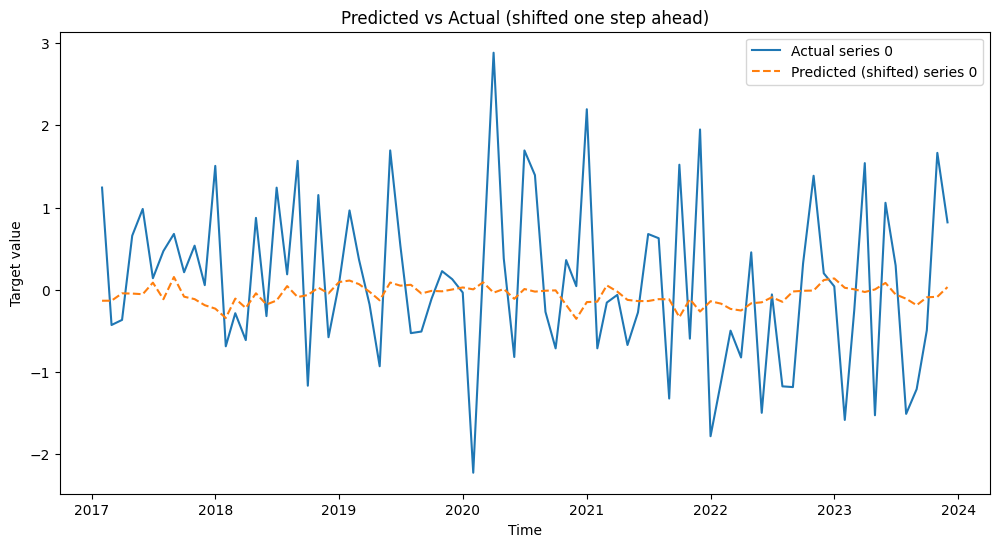

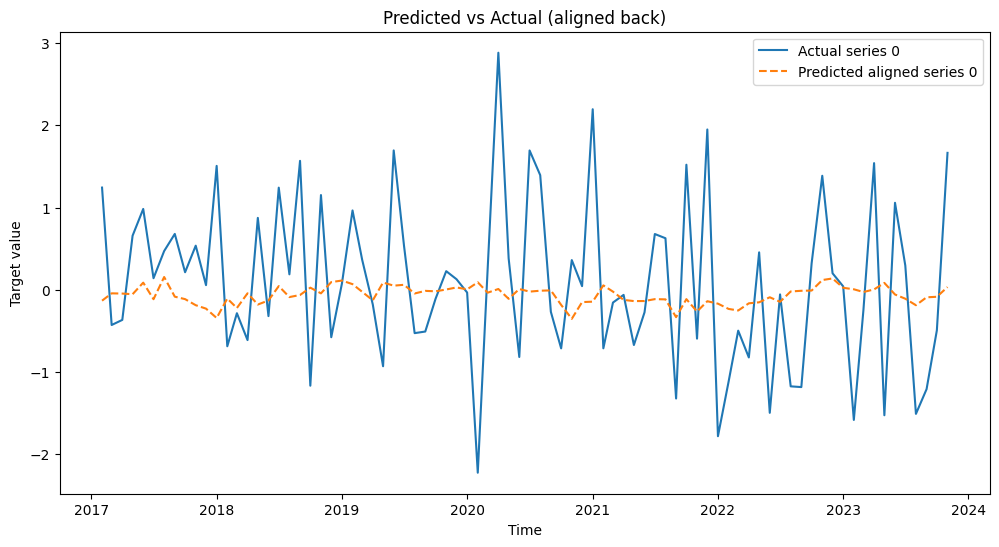

In [5]:
from model.prediction_engine import PredictionTestEngine

# Instantiate engine
window_size = 70
train_start = int(0.70 * X_all.shape[0])
engine = PredictionTestEngine(
    X_all,
    Y_all,
    window_size=window_size,
    time_index=time_index_all,
    train_start=train_start,
)

y_pred, y_true, times, metrics = engine.run_window(
    method="hopls_milr"
    , R=40, Ln=(6, 6), epsilon=1e-6, verbose=True, n_jobs=1, lambda_X = 1e-4, lambda_Y = 1e-7, alpha=1.2
)

print("Overall metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# Plot results for series 0
engine.plot_results(series_indices=[0])

run_window: X_all shape (275, 127, 38), y_all shape (275, 127)
run_window: window_size=90, n_series=127, n_features=38
run_window: number of test windows=138


Parallel preds:   0%|          | 0/138 [00:00<?, ?it/s]

Parallel preds: 100%|██████████| 138/138 [09:16<00:00,  4.03s/it]


MILR components: 15
  P comp 0: [(127, 20), (38, 20)]
  P comp 1: [(127, 20), (38, 20)]
  P comp 2: [(127, 20), (38, 20)]
  P comp 3: [(127, 20), (38, 20)]
  P comp 4: [(127, 20), (38, 20)]
  P comp 5: [(127, 20), (38, 20)]
  P comp 6: [(127, 20), (38, 20)]
  P comp 7: [(127, 20), (38, 20)]
  P comp 8: [(127, 20), (38, 20)]
  P comp 9: [(127, 20), (38, 20)]
  P comp 10: [(127, 20), (38, 20)]
  P comp 11: [(127, 20), (38, 20)]
  P comp 12: [(127, 20), (38, 20)]
  P comp 13: [(127, 20), (38, 20)]
  P comp 14: [(127, 20), (38, 20)]
G shapes: [(1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20)]
Q shape: (127, 15)
D shape: (15,)
T_mat shape: (90, 15), W_mat shape: (4826, 15)
Overall metrics:
mse: 0.8889
r2: 0.0005
directional_accuracy: 0.5074


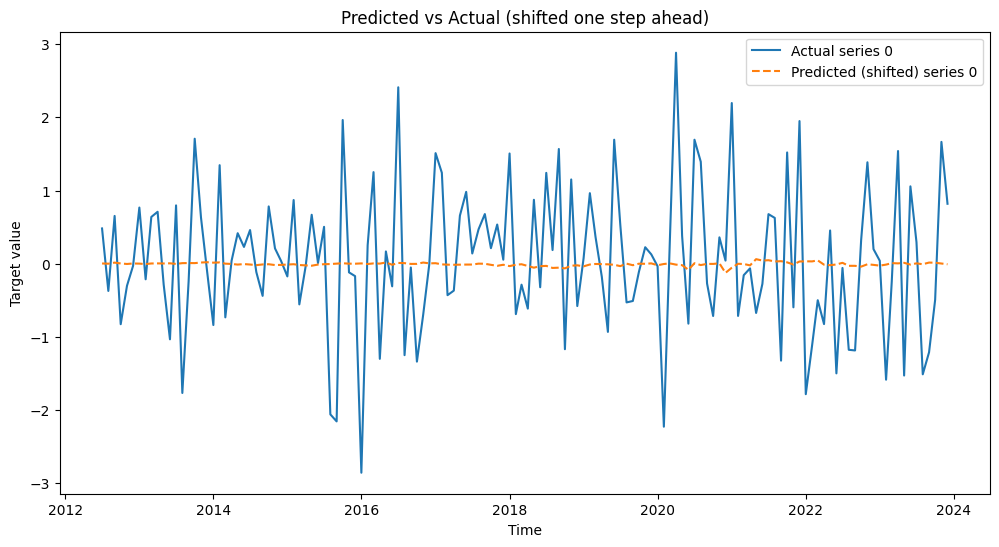

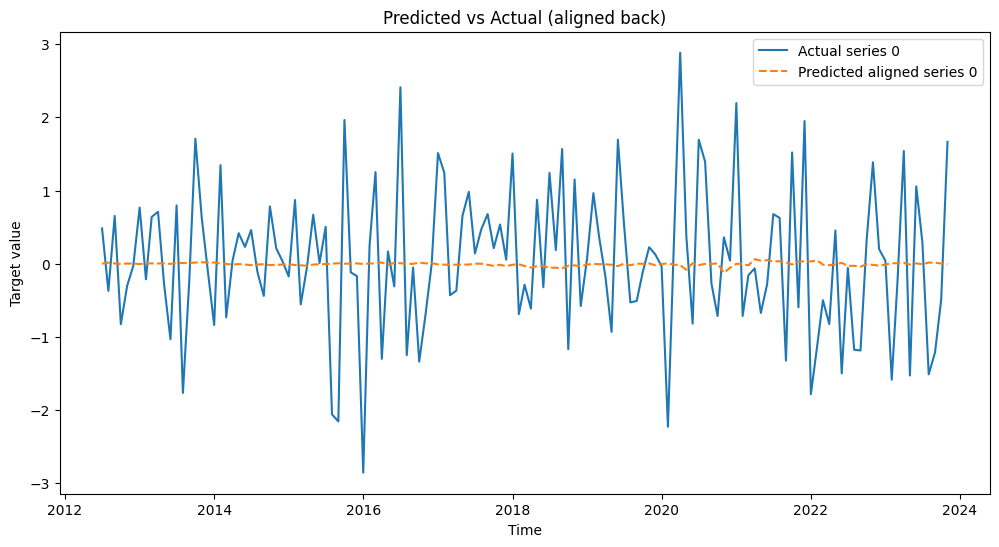

In [12]:
# Instantiate engine
window_size = 90
train_start = int(0.50 * X_all.shape[0])
engine = PredictionTestEngine(
    X_all,
    Y_all,
    window_size=window_size,
    time_index=time_index_all,
    train_start=train_start,
)

y_pred, y_true, times, metrics = engine.run_window(
    method="hopls_milr"
    , R=15, Ln=(20, 20), epsilon=1e-8, verbose=True, n_jobs=4, lambda_X = 1, lambda_Y = 1, alpha=0.03
)



print("Overall metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# Plot results for series 0
engine.plot_results(series_indices=[0])

In [ ]:
# Instantiate engine
window_size = 60
train_start = int(0.70 * X_all.shape[0])
engine = PredictionTestEngine(
    X_all,
    Y_all,
    window_size=window_size,
    time_index=time_index_all,
    train_start=train_start,
)

y_pred, y_true, times, metrics = engine.run_window(
    method="hopls_milr"
    , R=40, Ln=(6, 6), epsilon=1e-6, verbose=True, n_jobs=7, lambda_X = 1e-4, lambda_Y = 1e-7, alpha=4
)

print("Overall metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# Plot results for series 0
engine.plot_results(series_indices=[0])

In [ ]:
# Instantiate engine
window_size = 60
train_start = int(0.70 * X_all.shape[0])
engine = PredictionTestEngine(
    X_all,
    Y_all,
    window_size=window_size,
    time_index=time_index_all,
    train_start=train_start,
)

y_pred, y_true, times, metrics = engine.run_window(
    method="hopls_milr"
    , R=50, Ln=(12, 12), epsilon=1e-7, verbose=True, n_jobs=7, lambda_X = 1e-2, lambda_Y = 1e-7, alpha=4
)

print("Overall metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# Plot results for series 0
engine.plot_results(series_indices=[0])

In [ ]:
# Instantiate engine
window_size = 60
train_start = int(0.70 * X_all.shape[0])
engine = PredictionTestEngine(
    X_all,
    Y_all,
    window_size=window_size,
    time_index=time_index_all,
    train_start=train_start,
)

y_pred, y_true, times, metrics = engine.run_window(
    method="hopls_milr"
    , R=10, Ln=(8, 8), epsilon=1e-7, verbose=True, n_jobs=7, lambda_X = 1e-2, lambda_Y = 1e-7, alpha=2
)

print("Overall metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# Plot results for series 0
engine.plot_results(series_indices=[0])